# Feature importance

In [1]:
import pandas as pd
from pycaret.regression import RegressionExperiment

In [2]:
selected_coins = [
    'BTCUSDT', 'BNBUSDT', 'ETHUSDT', 'LTCUSDT'
]

In [3]:
def add_features(df):
    """Add technical indicators and features to the dataframe"""
    # Create a copy of the dataframe
    data = df.copy()

    # Add lagged features
    for lag in [1, 3, 5, 7, 14, 30]:
        data[f'close_lag_{lag}'] = data['close'].shift(lag)

    # Add rolling stats
    data['ma7'] = data['close'].rolling(window=7).mean()
    data['ma30'] = data['close'].rolling(window=30).mean()
    data['std7'] = data['close'].rolling(window=7).std()

    # Add price changes
    data['price_change_1d'] = data['close'].pct_change(1)
    data['price_change_7d'] = data['close'].pct_change(7)

    # Calculate RSI (14-period)
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['rsi'] = 100 - (100 / (1 + rs))

    # Drop rows with NaN values
    data = data.dropna()

    return data

,Description,Value
0,Session id,6364
1,Target,close
2,Target type,Regression
3,Original data shape,"(1795, 18)"
4,Transformed data shape,"(1795, 17)"
5,Transformed train set shape,"(1777, 17)"
6,Transformed test set shape,"(18, 17)"
7,Ignore features,1
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2157.5878,9260755.6808,3043.1490,0.9005,0.0575,0.0427
1,1156.0483,2173533.9245,1474.2910,0.9768,0.0642,0.0492
2,352.1513,190476.1343,436.4357,0.9921,0.0203,0.0158
3,918.0223,2838134.7852,1684.6765,0.9885,0.0255,0.0153
4,11528.2343,282937464.1273,16820.7451,-0.0246,0.2016,0.1219
Mean,3222.4088,59480072.9304,4691.8594,0.7667,0.0738,0.0490
Std,4193.7812,111770112.6093,6120.9908,0.3970,0.0661,0.0390



--- BTCUSDT --- 
{'open': 0.005961433335911065, 'high': 0.5010645375444165, 'low': 0.46002061927418636, 'volume': 3.627332197720872e-05, 'close_lag_1': 0.007174189088215163, 'close_lag_3': 0.008992620983934486, 'close_lag_5': 0.0003468237523877506, 'close_lag_7': 0.0002386261942335681, 'close_lag_14': 0.00017805625115379452, 'close_lag_30': 3.374335953371961e-05, 'ma7': 0.007823852851258108, 'ma30': 0.007545009459950968, 'std7': 3.0422401505283096e-05, 'price_change_1d': 0.00041179385379207055, 'price_change_7d': 5.185189260663904e-05, 'rsi': 9.014643493738578e-05}


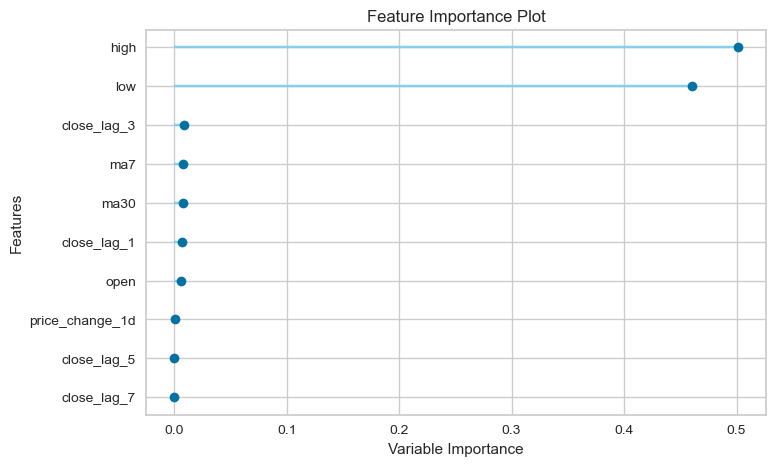

,Description,Value
0,Session id,5227
1,Target,close
2,Target type,Regression
3,Original data shape,"(1795, 18)"
4,Transformed data shape,"(1795, 17)"
5,Transformed train set shape,"(1777, 17)"
6,Transformed test set shape,"(18, 17)"
7,Ignore features,1
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,165.3390,40298.0918,200.7438,-1.9407,0.5049,0.3300
1,5.8625,65.9146,8.1188,0.9877,0.0245,0.0178
2,2.4041,10.7807,3.2834,0.9906,0.0111,0.0084
3,5.7686,98.7531,9.9375,0.9960,0.0210,0.0146
4,8.4979,167.1330,12.9280,0.9559,0.0198,0.0134
Mean,37.5744,8128.1346,47.0023,0.3979,0.1163,0.0769
Std,63.9116,16085.0582,76.9345,1.1694,0.1944,0.1266



--- BNBUSDT --- 
{'open': 0.002226893474065916, 'high': 0.12920875797483608, 'low': 0.7009833507570741, 'volume': 7.405738969209936e-05, 'close_lag_1': 0.008152099267052796, 'close_lag_3': 0.008161417944620468, 'close_lag_5': 0.04232890176110518, 'close_lag_7': 0.02563222462725048, 'close_lag_14': 0.036123759160064994, 'close_lag_30': 4.842287682581544e-05, 'ma7': 0.014256319995302157, 'ma30': 0.031843974462759536, 'std7': 9.849817389933663e-05, 'price_change_1d': 0.0007218276250504909, 'price_change_7d': 6.867653092028504e-05, 'rsi': 7.081797948020355e-05}


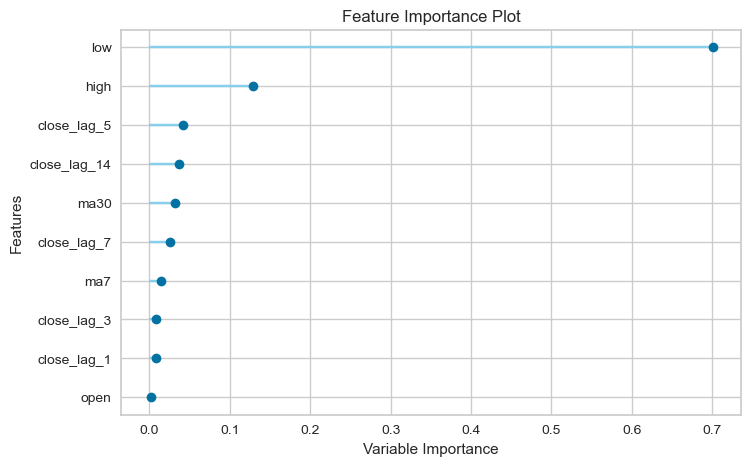

,Description,Value
0,Session id,322
1,Target,close
2,Target type,Regression
3,Original data shape,"(1795, 18)"
4,Transformed data shape,"(1795, 17)"
5,Transformed train set shape,"(1777, 17)"
6,Transformed test set shape,"(18, 17)"
7,Ignore features,1
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1190.1820,2147732.5547,1465.5144,-1.7775,0.5248,0.3320
1,48.8872,3838.5440,61.9560,0.9934,0.0399,0.0287
2,17.1459,493.8000,22.2216,0.9924,0.0141,0.0105
3,24.6126,1146.7883,33.8643,0.9980,0.0124,0.0093
4,26.5067,1540.2036,39.2454,0.9946,0.0143,0.0094
Mean,261.4669,430950.3781,324.5603,0.4402,0.1211,0.0780
Std,464.4784,858391.8278,570.6233,1.1088,0.2021,0.1272



--- ETHUSDT --- 
{'open': 0.00490467792836101, 'high': 0.7426127208149275, 'low': 0.21606335767500007, 'volume': 9.575312122545404e-05, 'close_lag_1': 0.007909765389071146, 'close_lag_3': 0.0002267549825603824, 'close_lag_5': 0.00012384837016136732, 'close_lag_7': 0.008759040016971947, 'close_lag_14': 5.978560290504427e-05, 'close_lag_30': 5.121869853075682e-05, 'ma7': 0.0042153143035558414, 'ma30': 0.013622356298763138, 'std7': 7.199572383490863e-05, 'price_change_1d': 0.0011423769925877924, 'price_change_7d': 8.052453722772263e-05, 'rsi': 6.0509544315964215e-05}


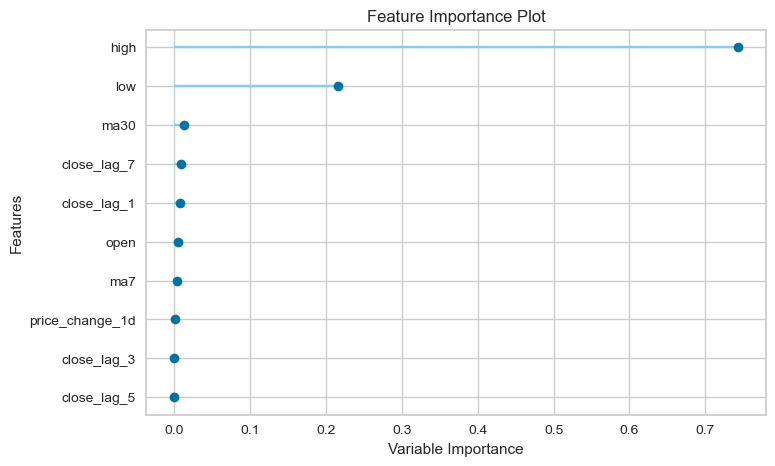

,Description,Value
0,Session id,7446
1,Target,close
2,Target type,Regression
3,Original data shape,"(1795, 18)"
4,Transformed data shape,"(1795, 17)"
5,Transformed train set shape,"(1777, 17)"
6,Transformed test set shape,"(18, 17)"
7,Ignore features,1
8,Numeric features,16
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12.7022,775.7244,27.8518,0.6980,0.1036,0.0511
1,2.5009,13.2102,3.6346,0.9860,0.0405,0.0305
2,1.8318,5.7991,2.4081,0.9583,0.0283,0.0219
3,0.7578,1.4223,1.1926,0.9868,0.0141,0.0098
4,1.1604,3.3687,1.8354,0.9934,0.0169,0.0121
Mean,3.7906,159.9049,7.3845,0.9245,0.0407,0.0251
Std,4.4952,307.9357,10.2652,0.1139,0.0328,0.0150



--- LTCUSDT --- 
{'open': 0.00044664476792711193, 'high': 0.5836933397242104, 'low': 0.4109094017766739, 'volume': 0.00018598999424671215, 'close_lag_1': 0.0008758886388180322, 'close_lag_3': 0.00012929862884184561, 'close_lag_5': 0.00011614031967786125, 'close_lag_7': 0.00013080721779219875, 'close_lag_14': 0.00011240421960584741, 'close_lag_30': 0.00016078434576752705, 'ma7': 0.00014460186143185055, 'ma30': 0.0006250280795818547, 'std7': 0.00020609317369832755, 'price_change_1d': 0.0013236815193226573, 'price_change_7d': 0.00036207279290850227, 'rsi': 0.000577822939495387}


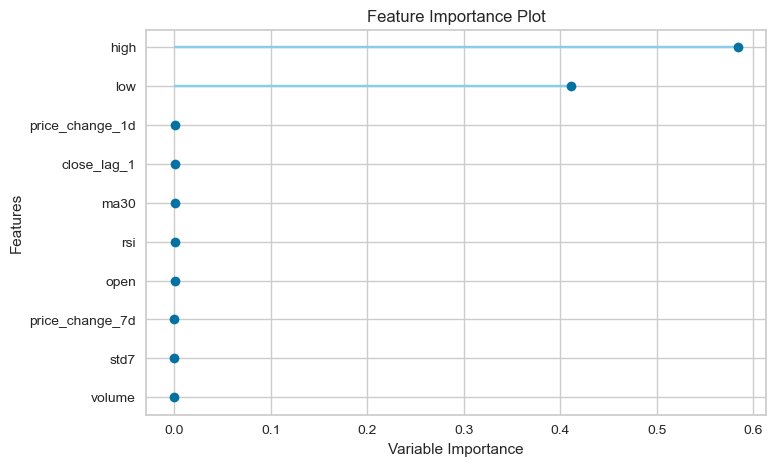

In [4]:
# Feature importance
for coin in selected_coins:
    df_filename = coin.lower() + "_1d.csv"
    df = pd.read_csv("../backend/data/"+df_filename, parse_dates=True, index_col=0)
    df = add_features(df)
    fi_exp = RegressionExperiment().setup(df, target = 'close', ignore_features = ['symbol'],
                                          data_split_shuffle=False,
                                          fold=5, fold_strategy='timeseries', train_size=0.99)
    rf = fi_exp.create_model('rf')
    final_rf = fi_exp.finalize_model(rf)
    print(f"\n--- {coin} --- ")
    print({feat: imp for feat,imp in zip(final_rf.feature_names_in_, final_rf.feature_importances_)})
    fi_exp.plot_model(final_rf, plot='feature')

## observations

For the representative coins, the following features are of significant importance:

- lag 1, 3, 5
- 7 day and 30 day moving average

In [77]:
coins = []
for coin in selected_coins:
    df_filename = coin.lower() + "_1d.csv"
    df = pd.read_csv("../backend/data/"+df_filename, parse_dates=True, index_col=0)
    # print(df[['close']].T.head().to_markdown())
    
    piv = df[['close', 'symbol']].pivot_table(
        values='close',
        columns="symbol",
        index=df.index
    )
    coins.append(piv)
coins_df = pd.concat(coins, axis=1)

coins_df.head()

symbol,BTCUSDT,BNBUSDT,ETHUSDT,LTCUSDT
timestamp,,,,
2020-04-20,6826.83,14.9892,170.20,40.21
2020-04-21,6841.37,15.1283,170.74,40.59
2020-04-22,7125.14,15.7104,182.70,41.80
2020-04-23,7482.39,16.0340,185.51,42.98
2020-04-24,7505.00,15.9319,187.59,44.53


In [81]:
coins = []
all_coin_df = pd.DataFrame()
for coin in selected_coins:
    df_filename = coin.lower() + "_1d.csv"
    df = pd.read_csv("../backend/data/"+df_filename, parse_dates=True, index_col=0)
    if len(df) == 0:
        continue
    close_series = df['close'].copy()
    close_series.name = coin
    
    if all_coin_df.empty:
        all_coin_df = pd.DataFrame(close_series)
    else:
        # inner should keep only matching timestamps
        all_coin_df = all_coin_df.join(close_series, how='inner')

all_coin_df

,BTCUSDT,BNBUSDT,ETHUSDT,LTCUSDT
timestamp,,,,
2020-04-20,6826.83,14.9892,170.20,40.21
2020-04-21,6841.37,15.1283,170.74,40.59
2020-04-22,7125.14,15.7104,182.70,41.80
2020-04-23,7482.39,16.0340,185.51,42.98
2020-04-24,7505.00,15.9319,187.59,44.53
...,...,...,...,...
2025-04-14,84591.58,584.5400,1623.77,77.18
2025-04-15,83643.99,579.5200,1588.78,75.27
2025-04-16,84030.38,582.8000,1577.14,74.33


In [86]:
corr_m = all_coin_df.corr()
corr_m
foo = corr_m['BTCUSDT'].drop("BTCUSDT").nsmallest(2)
foo
# for item in foo.items():
#     print(item)


LTCUSDT    0.363169
ETHUSDT    0.751745
Name: BTCUSDT, dtype: float64